# Base Characteristics

In [1]:
# Graph: Distribution of engine lifespans (histogram)

def plot_engine_lifespan_hist(df, dataset_name="FD001", bins=20, savepath=None, ax=None):
    """
    Plot a histogram of engine lifespans (max cycles per unit) using the
    C-MAPSS column names: 'unit_number' and 'time_in_cycles'.

    Args:
        df (pd.DataFrame): Raw or preprocessed dataset with required columns.
        dataset_name (str): Label used in the plot title.
        bins (int): Number of histogram bins.
        savepath (str | Path | None): If provided, saves the figure.
        ax (matplotlib.axes.Axes | None): Optional axes to draw on.

    Returns:
        pd.Series: Lifespan (max cycles) per engine, indexed by unit_number.
    """
    required_cols = {"unit_number", "time_in_cycles"}
    missing = required_cols - set(df.columns)
    if missing:
        raise KeyError(f"Missing columns {missing}. Expected {required_cols}.")

    # Compute lifespan per engine (max cycles before failure)
    lifespans = df.groupby("unit_number")["time_in_cycles"].max().sort_values()

    # Prepare axes
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        created_fig = True

    # Plot histogram
    ax.hist(lifespans, bins=bins, edgecolor="black")
    ax.set_title(f"Distribution of Engine Lifespans ({dataset_name})")
    ax.set_xlabel("Max Cycles Before Failure")
    ax.set_ylabel("Number of Engines")
    ax.grid(True, linestyle="--", alpha=0.5)

    # Annotate mean ± std for quick reference
    mean_cycles = lifespans.mean()
    std_cycles = lifespans.std()
    ax.axvline(mean_cycles, linestyle="--", linewidth=1)
    ax.text(mean_cycles, ax.get_ylim()[1] * 0.95,
            f"mean={mean_cycles:.1f}\nσ={std_cycles:.1f}",
            ha="center", va="top")

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")

    if created_fig:
        plt.tight_layout()
        plt.show()

    return lifespans

#================================================================================================================

# Graph: example rul trajectories
from typing import Iterable, Dict, List, Optional, Tuple

def plot_example_rul_trajectories(df, unit_ids, max_rul=130,
                                   dataset_name="FD001", savepath=None):
    """Line plots of RUL vs cycles for selected engines."""
    import matplotlib.pyplot as plt
    import pre_processing as pp

    df = df.copy()
    df = pp.calculate_rul(df, max_rul=max_rul)
    plt.figure(figsize=(10, 6))

    for uid in unit_ids:
        g = df[df.unit_number == uid].sort_values('time_in_cycles')
        plt.plot(g['time_in_cycles'], g['RUL'],
                 marker='.', linewidth=1, label=f"Engine {uid}")

    plt.title(f"Example RUL Trajectories ({dataset_name})")
    plt.xlabel("Cycle")
    plt.ylabel("RUL")
    plt.legend(ncol=2, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    
#====================================================================================================================

# Graph: Sensor correlation heatmap
def plot_sensor_correlation_heatmap(df, dataset_name="FD001", method="pearson", savepath=None):
    """
    Plot a correlation heatmap for C-MAPSS sensor columns (sensor_measurement_*).

    Args:
        df (pd.DataFrame): DataFrame with sensor columns.
        dataset_name (str): Label for the title.
        method (str): Correlation method ('pearson', 'spearman', 'kendall').
        savepath (str|Path|None): If provided, save the figure.

    Returns:
        pd.DataFrame: Correlation matrix used for the plot.
    """
    import matplotlib.pyplot as plt

    sensor_cols = [c for c in df.columns if c.startswith("sensor_measurement")]
    if not sensor_cols:
        raise ValueError("No sensor_measurement_* columns found.")

    corr = df[sensor_cols].corr(method=method)

    # Prefer seaborn if available, else matplotlib fallback
    try:
        import seaborn as sns
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, cmap="coolwarm", center=0, square=True,
                    linewidths=0.5, cbar_kws={"shrink": 0.8})
    except Exception:
        plt.figure(figsize=(12, 10))
        im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        labels = [s.replace("sensor_measurement_", "S") for s in sensor_cols]
        plt.xticks(range(len(sensor_cols)), labels, rotation=90)
        plt.yticks(range(len(sensor_cols)), labels)

    plt.title(f"Sensor Correlation Heatmap ({dataset_name})")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

    return corr

#======================================================================================================================

import numpy as np
import pandas as pd

def summarize_sensor_correlations(df, method="pearson", top_k=5):
    """
    Summarize inter-sensor correlations and list top +/- pairs.

    Returns:
        stats (dict): mean/median of corr and |corr| over unique pairs
        top_pos (pd.DataFrame): top-k most positively correlated pairs
        top_neg (pd.DataFrame): top-k most negatively correlated pairs
        corr (pd.DataFrame): full correlation matrix for reuse
    """
    sensor_cols = [c for c in df.columns if c.startswith("sensor_measurement")]
    if len(sensor_cols) < 2:
        raise ValueError("Need at least two sensor_measurement_* columns.")

    corr = df[sensor_cols].corr(method=method)

    # take upper triangle (unique pairs, exclude diagonal)
    iu = np.triu_indices_from(corr, k=1)
    pair_list = []
    for i, j in zip(iu[0], iu[1]):
        pair_list.append({
            "sensor_a": sensor_cols[i],
            "sensor_b": sensor_cols[j],
            "corr": corr.iloc[i, j],
            "abs_corr": abs(corr.iloc[i, j]),
        })
    pairs = pd.DataFrame(pair_list)

    # summary stats
    stats = {
        "mean_corr": float(pairs["corr"].mean()),
        "median_corr": float(pairs["corr"].median()),
        "mean_abs_corr": float(pairs["abs_corr"].mean()),
        "median_abs_corr": float(pairs["abs_corr"].median()),
        "n_pairs": int(len(pairs)),
    }

    # top-k lists
    top_pos = pairs.sort_values("corr", ascending=False).head(top_k).reset_index(drop=True)
    top_neg = pairs.sort_values("corr", ascending=True ).head(top_k).reset_index(drop=True)

    return stats, top_pos, top_neg, corr


In [2]:
# Load Dataset


# Standard libs
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import joblib


# Project modules
import data_loader as dl
import pre_processing as pp
import evaluator as ev
import base_model as base
import lstm_model as lstm
import cnn_model as cnn
import cnn_lstm_model as cnnlstm

# ---- Paths ----
ROOT = Path.cwd()
CMAPS = ROOT / "CMaps"  # keep correct folder case
# ==== Minimal config you tweak next time ====
DATASET = "FD004"       # <— change this to FD002/FD003/FD004 later
SEQ_LEN = 30            # sliding window
MAX_RUL = 130           # RUL clipping
VAL_SPLIT = 0.30        # val split by unit

# Files derived from DATASET (so you edit one line only)
TRAIN_PATH = CMAPS / f"train_{DATASET}.txt"
TEST_PATH  = CMAPS / f"test_{DATASET}.txt"
RUL_PATH   = CMAPS / f"RUL_{DATASET}.txt"

# Artifacts folder for this dataset
ART_DIR = ROOT / f"{DATASET} data & artefacts"
ART_DIR.mkdir(exist_ok=True)

print(f"backend: torch | dataset: {DATASET}")
print("Train:", TRAIN_PATH.name, "| Test:", TEST_PATH.name, "| RUL:", RUL_PATH.name)


# --- Load FD001 ---
train_df = dl.load_raw_data(CMAPS / f"train_{DATASET}.txt")
test_df, rul_df = dl.load_test_data(
    CMAPS / f"test_{DATASET}.txt",
    CMAPS / f"RUL_{DATASET}.txt"
)

print("Loaded.")
print("  train_df:", train_df.shape, "  test_df:", test_df.shape, "  rul_df:", rul_df.shape)
assert train_df.shape[1] == 26 and test_df.shape[1] == 26

backend: torch | dataset: FD004
Train: train_FD004.txt | Test: test_FD004.txt | RUL: RUL_FD004.txt
Loaded.
  train_df: (61249, 26)   test_df: (41214, 26)   rul_df: (248, 1)


# Preamble

In [3]:
dl.inspect_data(train_df)

Shape: (61249, 26)

Unique engines: 249

Missing values:
 0

Max cycles per engine:
count    249.00000
mean     245.97992
std       73.11080
min      128.00000
25%      190.00000
50%      234.00000
75%      290.00000
max      543.00000
Name: time_in_cycles, dtype: float64

First 5 rows:


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


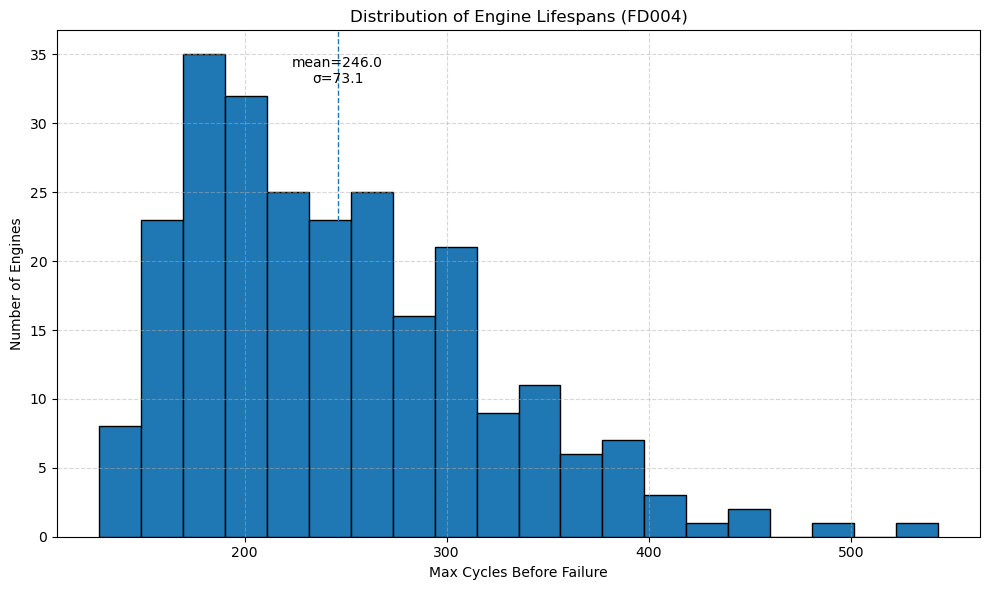

unit_number
214    128
115    131
181    134
156    139
36     143
      ... 
179    435
49     446
173    457
133    489
118    543
Name: time_in_cycles, Length: 249, dtype: int64

In [4]:
plot_engine_lifespan_hist(train_df, dataset_name=DATASET)

In [5]:
import numpy as np

def select_representative_units(df, random_state=42):
    """
    Select representative engine units:
    - Shortest-lived
    - Median-lived
    - Longest-lived
    - One random unit (reproducible with random_state)

    Args:
        df (pd.DataFrame): Engine dataset with 'unit_number' and 'time_in_cycles'.
        random_state (int): Seed for reproducibility.

    Returns:
        list[int]: List of selected engine IDs.
    """
    # Compute max cycles per engine
    lifespans = df.groupby("unit_number")["time_in_cycles"].max().sort_values()

    # Shortest-lived
    shortest = lifespans.index[0]
    # Median-lived
    median = lifespans.index[len(lifespans) // 2]
    # Longest-lived
    longest = lifespans.index[-1]
    # One random
    rng = np.random.default_rng(random_state)
    random_unit = rng.choice(lifespans.index)

    return [shortest, median, longest, int(random_unit)]


Selected engines: [214, 147, 118, 27]


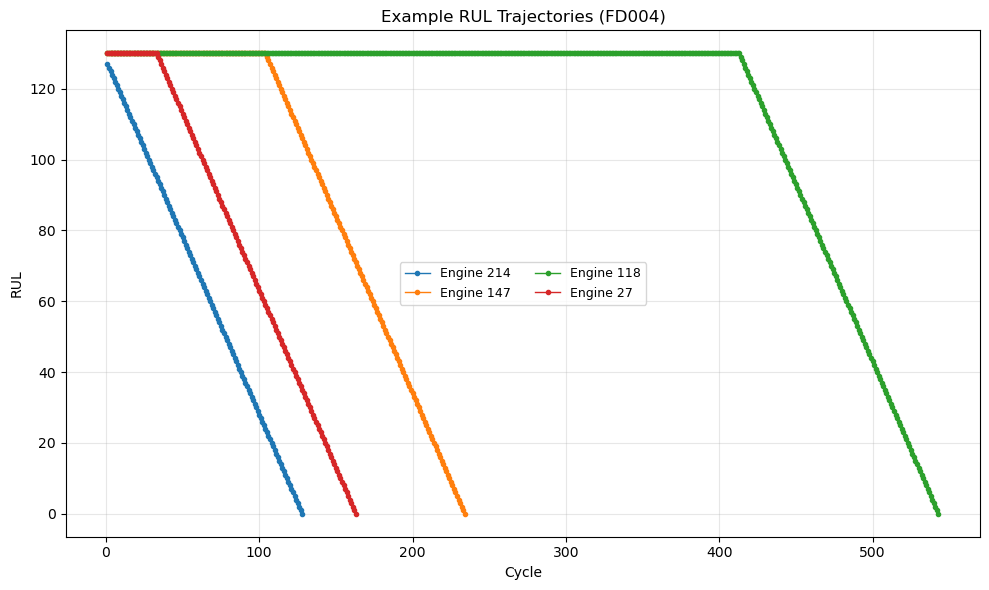

In [6]:
example_units = select_representative_units(train_df, random_state=42)
print("Selected engines:", example_units)

plot_example_rul_trajectories(train_df, unit_ids=example_units,
                              max_rul=MAX_RUL, dataset_name=DATASET)


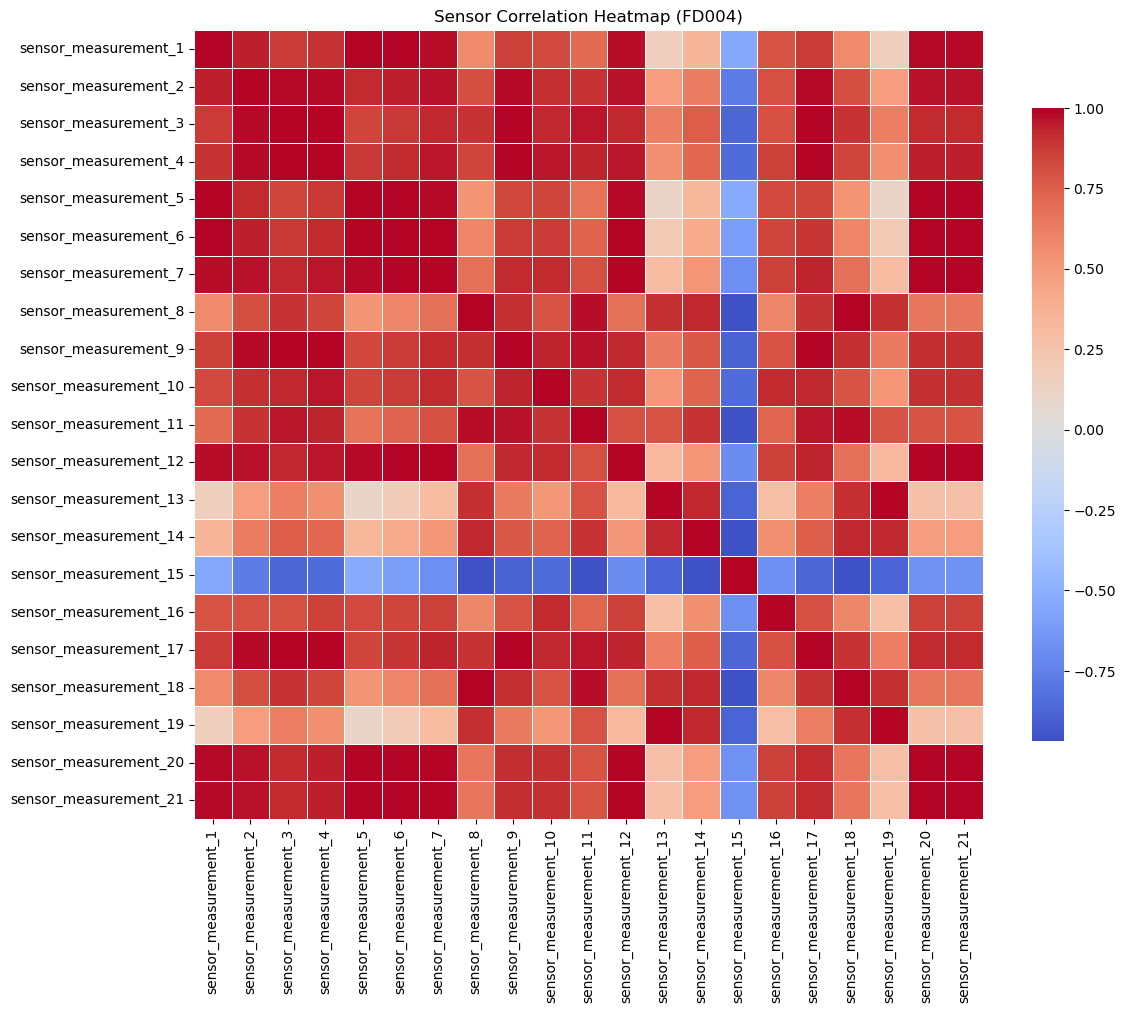

,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
sensor_measurement_1,1.000000,0.944439,0.870606,0.897421,0.986561,0.986539,0.973191,0.572469,0.861569,0.823653,...,0.972915,0.163834,0.353450,-0.542375,0.789447,0.872955,0.572078,0.163835,0.977777,0.977791
sensor_measurement_2,0.944439,1.000000,0.981750,0.980722,0.916509,0.944587,0.968979,0.809878,0.978305,0.904535,...,0.969187,0.478666,0.624368,-0.776156,0.800320,0.982621,0.809591,0.478659,0.962824,0.962806
sensor_measurement_3,0.870606,0.981750,1.000000,0.989744,0.842817,0.884586,0.929013,0.895268,0.998190,0.929839,...,0.929499,0.620227,0.755184,-0.875041,0.801512,0.998693,0.895021,0.620181,0.917055,0.917020
sensor_measurement_4,0.897421,0.980722,0.989744,1.000000,0.883579,0.919064,0.956314,0.843898,0.987901,0.961264,...,0.956736,0.544531,0.719325,-0.846000,0.858554,0.990407,0.843615,0.544482,0.945999,0.945965
sensor_measurement_5,0.986561,0.916509,0.842817,0.883579,1.000000,0.996316,0.979719,0.524506,0.832973,0.840662,...,0.979416,0.113473,0.331134,-0.525064,0.824766,0.845583,0.524096,0.113471,0.985677,0.985696
sensor_measurement_6,0.986539,0.944587,0.884586,0.919064,0.996316,1.000000,0.993180,0.594557,0.876139,0.875562,...,0.993003,0.197794,0.408114,-0.594836,0.841052,0.887014,0.594169,0.197793,0.996289,0.996299
sensor_measurement_7,0.973191,0.968979,0.929013,0.956314,0.979719,0.993180,1.000000,0.679196,0.922913,0.916964,...,0.999993,0.306696,0.510037,-0.683952,0.859296,0.930983,0.678835,0.306687,0.999142,0.999140
sensor_measurement_8,0.572469,0.809878,0.895268,0.843898,0.524506,0.594557,0.679196,1.000000,0.903340,0.786392,...,0.680196,0.902626,0.925392,-0.968781,0.586144,0.893198,0.999999,0.902625,0.655978,0.655907
sensor_measurement_9,0.861569,0.978305,0.998190,0.987901,0.832973,0.876139,0.922913,0.903340,1.000000,0.930810,...,0.923424,0.634705,0.772075,-0.886023,0.797609,0.998212,0.903079,0.634634,0.910335,0.910293
sensor_measurement_10,0.823653,0.904535,0.929839,0.961264,0.840662,0.875562,0.916964,0.786392,0.930810,1.000000,...,0.917452,0.514096,0.735566,-0.851154,0.923032,0.930554,0.786177,0.514065,0.907217,0.907159


In [7]:
plot_sensor_correlation_heatmap(train_df, dataset_name=DATASET)

In [8]:
stats, top_pos, top_neg, corr = summarize_sensor_correlations(train_df, method="pearson", top_k=5)

print("Correlation summary:", {k: round(v, 3) if isinstance(v, float) else v for k, v in stats.items()})

display(top_pos.round(3))
display(top_neg.round(3))

Correlation summary: {'mean_corr': 0.633, 'median_corr': 0.845, 'mean_abs_corr': 0.783, 'median_abs_corr': 0.873, 'n_pairs': 210}


,sensor_a,sensor_b,corr,abs_corr
0,sensor_measurement_8,sensor_measurement_18,1.000,1.000
1,sensor_measurement_13,sensor_measurement_19,1.000,1.000
2,sensor_measurement_7,sensor_measurement_12,1.000,1.000
3,sensor_measurement_20,sensor_measurement_21,1.000,1.000
4,sensor_measurement_7,sensor_measurement_20,0.999,0.999


,sensor_a,sensor_b,corr,abs_corr
0,sensor_measurement_8,sensor_measurement_15,-0.969,0.969
1,sensor_measurement_15,sensor_measurement_18,-0.969,0.969
2,sensor_measurement_11,sensor_measurement_15,-0.964,0.964
3,sensor_measurement_14,sensor_measurement_15,-0.963,0.963
4,sensor_measurement_9,sensor_measurement_15,-0.886,0.886


In [9]:
train__clean = pp.drop_flat_sensors(train_df.copy())

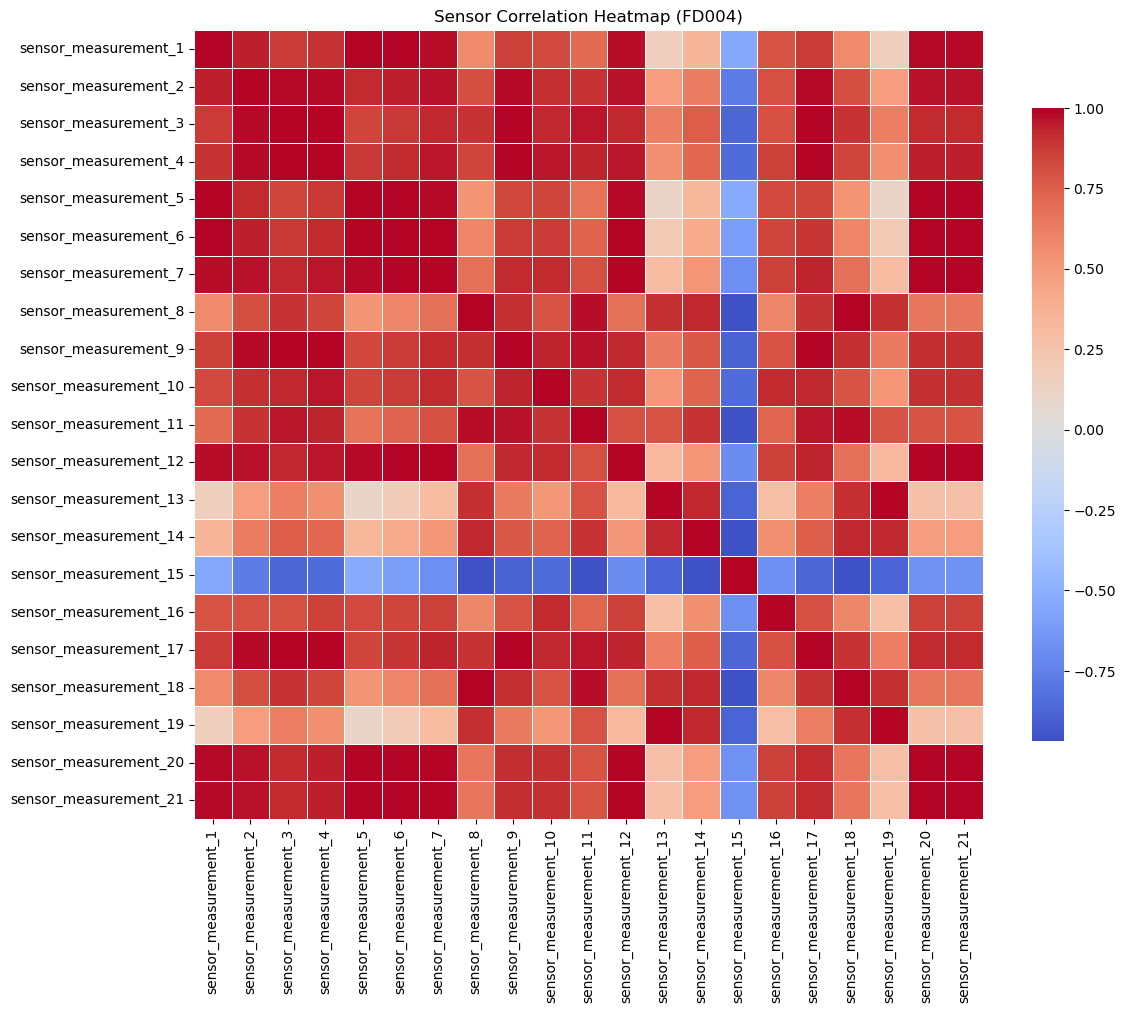

,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
sensor_measurement_1,1.000000,0.944439,0.870606,0.897421,0.986561,0.986539,0.973191,0.572469,0.861569,0.823653,...,0.972915,0.163834,0.353450,-0.542375,0.789447,0.872955,0.572078,0.163835,0.977777,0.977791
sensor_measurement_2,0.944439,1.000000,0.981750,0.980722,0.916509,0.944587,0.968979,0.809878,0.978305,0.904535,...,0.969187,0.478666,0.624368,-0.776156,0.800320,0.982621,0.809591,0.478659,0.962824,0.962806
sensor_measurement_3,0.870606,0.981750,1.000000,0.989744,0.842817,0.884586,0.929013,0.895268,0.998190,0.929839,...,0.929499,0.620227,0.755184,-0.875041,0.801512,0.998693,0.895021,0.620181,0.917055,0.917020
sensor_measurement_4,0.897421,0.980722,0.989744,1.000000,0.883579,0.919064,0.956314,0.843898,0.987901,0.961264,...,0.956736,0.544531,0.719325,-0.846000,0.858554,0.990407,0.843615,0.544482,0.945999,0.945965
sensor_measurement_5,0.986561,0.916509,0.842817,0.883579,1.000000,0.996316,0.979719,0.524506,0.832973,0.840662,...,0.979416,0.113473,0.331134,-0.525064,0.824766,0.845583,0.524096,0.113471,0.985677,0.985696
sensor_measurement_6,0.986539,0.944587,0.884586,0.919064,0.996316,1.000000,0.993180,0.594557,0.876139,0.875562,...,0.993003,0.197794,0.408114,-0.594836,0.841052,0.887014,0.594169,0.197793,0.996289,0.996299
sensor_measurement_7,0.973191,0.968979,0.929013,0.956314,0.979719,0.993180,1.000000,0.679196,0.922913,0.916964,...,0.999993,0.306696,0.510037,-0.683952,0.859296,0.930983,0.678835,0.306687,0.999142,0.999140
sensor_measurement_8,0.572469,0.809878,0.895268,0.843898,0.524506,0.594557,0.679196,1.000000,0.903340,0.786392,...,0.680196,0.902626,0.925392,-0.968781,0.586144,0.893198,0.999999,0.902625,0.655978,0.655907
sensor_measurement_9,0.861569,0.978305,0.998190,0.987901,0.832973,0.876139,0.922913,0.903340,1.000000,0.930810,...,0.923424,0.634705,0.772075,-0.886023,0.797609,0.998212,0.903079,0.634634,0.910335,0.910293
sensor_measurement_10,0.823653,0.904535,0.929839,0.961264,0.840662,0.875562,0.916964,0.786392,0.930810,1.000000,...,0.917452,0.514096,0.735566,-0.851154,0.923032,0.930554,0.786177,0.514065,0.907217,0.907159


In [10]:
plot_sensor_correlation_heatmap(train__clean, dataset_name=DATASET)

In [11]:
stats, top_pos, top_neg, corr = summarize_sensor_correlations(train__clean, method="pearson", top_k=5)

print("Correlation summary:", {k: round(v, 3) if isinstance(v, float) else v for k, v in stats.items()})

display(top_pos.round(3))
display(top_neg.round(3))

Correlation summary: {'mean_corr': 0.633, 'median_corr': 0.845, 'mean_abs_corr': 0.783, 'median_abs_corr': 0.873, 'n_pairs': 210}


,sensor_a,sensor_b,corr,abs_corr
0,sensor_measurement_8,sensor_measurement_18,1.000,1.000
1,sensor_measurement_13,sensor_measurement_19,1.000,1.000
2,sensor_measurement_7,sensor_measurement_12,1.000,1.000
3,sensor_measurement_20,sensor_measurement_21,1.000,1.000
4,sensor_measurement_7,sensor_measurement_20,0.999,0.999


,sensor_a,sensor_b,corr,abs_corr
0,sensor_measurement_8,sensor_measurement_15,-0.969,0.969
1,sensor_measurement_15,sensor_measurement_18,-0.969,0.969
2,sensor_measurement_11,sensor_measurement_15,-0.964,0.964
3,sensor_measurement_14,sensor_measurement_15,-0.963,0.963
4,sensor_measurement_9,sensor_measurement_15,-0.886,0.886
